In [2]:
DS = pd.read_csv("IC_APPROX_DATASET.csv")
DS["pearson"] = (
    DS["pearson"]
    .astype(str)
    .str.replace(r"tensor\(|\)", "", regex=True)
    .astype(float)
)

In [54]:
df[(df["dataset"]=="Epinions") & (df["edge_method"]=="random_0.1") & (df["prob_selected"]==0.01)].groupby(["approximation"])["rmse"].median()

approximation
ALE_heuristic    0.116337
Naive            0.076533
SWE              0.002162
dmp_ic_fast      0.076527
dmp_inf          0.002130
dmp_um_fast      0.076542
modified_ALE     0.057669
um_IC            0.002887
Name: rmse, dtype: float64

In [64]:
df.groupby(["approximation"])["auc"].min()

approximation
ALE_heuristic    0.583775
Naive            0.485070
SWE              0.996507
dmp_ic_fast      0.488826
dmp_inf          0.994827
dmp_um_fast      0.488819
modified_ALE     0.797226
um_IC            0.992084
Name: auc, dtype: float64

In [17]:
DS.describe()

,prob_selected,time_mc,T,L,time_ic_apporx,rmse,pearson,spearman,auc
count,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000
mean,0.103333,993.555173,5.848958,0.315104,0.798706,0.103277,0.875722,0.910499,0.953269
std,0.077613,1154.232105,3.132583,0.925560,1.257394,0.115826,0.220965,0.144660,0.099837
min,0.010000,7.951326,1.000000,0.000000,0.042847,0.000709,0.006800,0.159030,0.485070
25%,0.010000,242.331873,3.000000,0.000000,0.096997,0.014291,0.863600,0.897559,0.969259
50%,0.100000,275.483158,5.000000,0.000000,0.430902,0.048865,0.986750,0.980576,0.997806
75%,0.200000,1486.016061,10.000000,0.000000,0.848027,0.177607,0.998525,0.998273,0.999556
max,0.200000,3606.862111,10.000000,5.000000,6.904715,0.564793,1.000000,0.999908,0.999999


In [24]:
print(DS.info)

<bound method DataFrame.info of        dataset  prob_selected   edge_method      time_mc  approximation   T  \
0     Advogato           0.01    random_0.1   228.344927            SWE   8   
1     Advogato           0.01    random_0.1   228.344927          um_IC   9   
2     Advogato           0.01    random_0.1   228.344927    dmp_um_fast   8   
3     Advogato           0.01    random_0.1   228.344927          Naive   8   
4     Advogato           0.01    random_0.1   228.344927    dmp_ic_fast   7   
...        ...            ...           ...          ...            ...  ..   
3835  Epinions           0.20  degree_based  1982.717057          Naive   9   
3836  Epinions           0.20  degree_based  1982.717057    dmp_ic_fast  10   
3837  Epinions           0.20  degree_based  1982.717057        dmp_inf  10   
3838  Epinions           0.20  degree_based  1982.717057   modified_ALE   3   
3839  Epinions           0.20  degree_based  1982.717057  ALE_heuristic   2   

      L  time_ic_ap

In [26]:
df = DS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Defensive: fix the common typo in your column name if needed
if "time_ic_apporx" in df.columns and "time_ic_approx" not in df.columns:
    df = df.rename(columns={"time_ic_apporx": "time_ic_approx"})

# Derived metrics that make plots 10x more informative
df = df.copy()
df["speedup"] = df["time_mc"] / df["time_ic_approx"]
df["log_speedup"] = np.log10(df["speedup"])
df["log_time_ic_approx"] = np.log10(df["time_ic_approx"])

# Optional: normalize RMSE so "everything small" doesn't make errors look fake-good
# (per dataset/prob_selected/edge_method so it’s comparable within a condition)
group_cols = ["dataset", "prob_selected", "edge_method"]
df["rmse_z"] = df["rmse"] / (df.groupby(group_cols)["rmse"].transform("std").replace(0, np.nan))


In [27]:
metrics = ["rmse", "spearman", "auc", "time_ic_approx", "speedup"]

summary = (df.groupby(["approximation"])
             .agg(
                 rmse_median=("rmse", "median"),
                 spearman_median=("spearman", "median"),
                 auc_median=("auc", "median"),
                 time_median=("time_ic_approx", "median"),
                 speedup_median=("speedup", "median"),
                 n=("rmse", "size"),
             )
             .sort_values(["rmse_median", "time_median"])
          )

summary


,rmse_median,spearman_median,auc_median,time_median,speedup_median,n
approximation,,,,,,
dmp_inf,0.009266,0.999049,0.999786,1.027215,511.528184,480
SWE,0.010115,0.998602,0.999575,0.255347,3216.801335,480
um_IC,0.017481,0.997905,0.999099,0.251579,3244.659577,480
modified_ALE,0.072704,0.975511,0.967895,0.220380,4127.152437,480
dmp_um_fast,0.137685,0.906091,0.993758,0.802048,952.507292,480
dmp_ic_fast,0.138084,0.906855,0.993730,0.543064,1314.897262,480
Naive,0.138527,0.906294,0.992200,0.520129,1857.045795,480
ALE_heuristic,0.198362,0.907085,0.974423,0.219170,4263.362991,480


In [28]:
summary2 = summary.copy()
summary2["score"] = (
    -summary2["rmse_median"].rank(method="average")  # lower rmse better
    + summary2["spearman_median"].rank(method="average")
    + summary2["auc_median"].rank(method="average")
    + summary2["speedup_median"].rank(method="average")
)
summary2.sort_values("score", ascending=False)


,rmse_median,spearman_median,auc_median,time_median,speedup_median,n,score
approximation,,,,,,,
SWE,0.010115,0.998602,0.999575,0.255347,3216.801335,480,17.0
dmp_inf,0.009266,0.999049,0.999786,1.027215,511.528184,480,16.0
um_IC,0.017481,0.997905,0.999099,0.251579,3244.659577,480,15.0
modified_ALE,0.072704,0.975511,0.967895,0.220380,4127.152437,480,9.0
ALE_heuristic,0.198362,0.907085,0.974423,0.219170,4263.362991,480,6.0
dmp_ic_fast,0.138084,0.906855,0.993730,0.543064,1314.897262,480,4.0
dmp_um_fast,0.137685,0.906091,0.993758,0.802048,952.507292,480,3.0
Naive,0.138527,0.906294,0.992200,0.520129,1857.045795,480,2.0


/tmp/ipykernel_745143/78039953.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


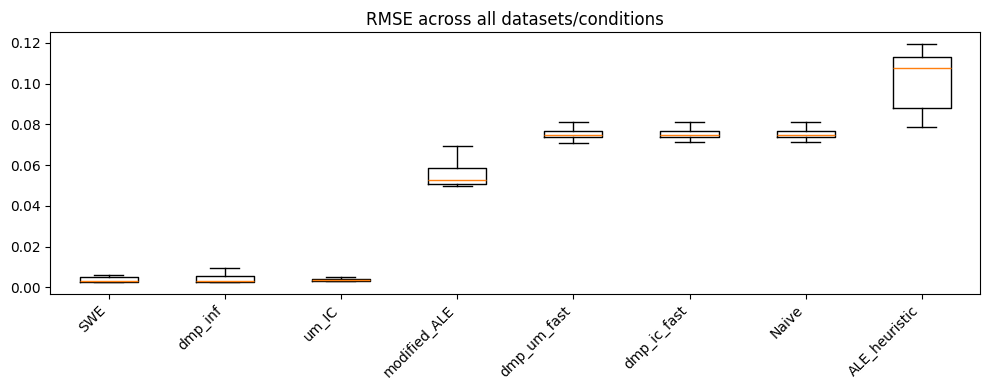

/tmp/ipykernel_745143/78039953.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


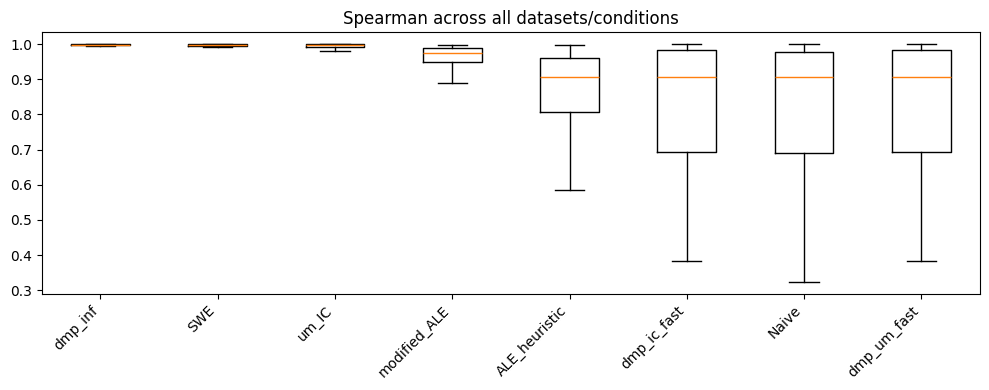

/tmp/ipykernel_745143/78039953.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


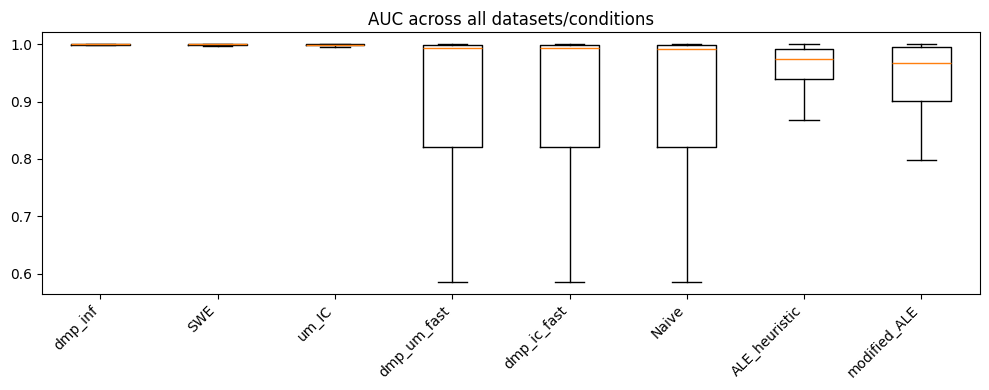

/tmp/ipykernel_745143/78039953.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


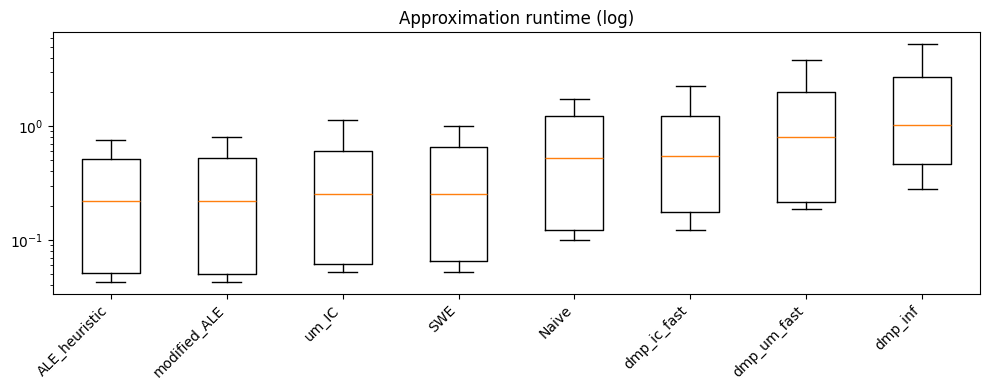

/tmp/ipykernel_745143/78039953.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


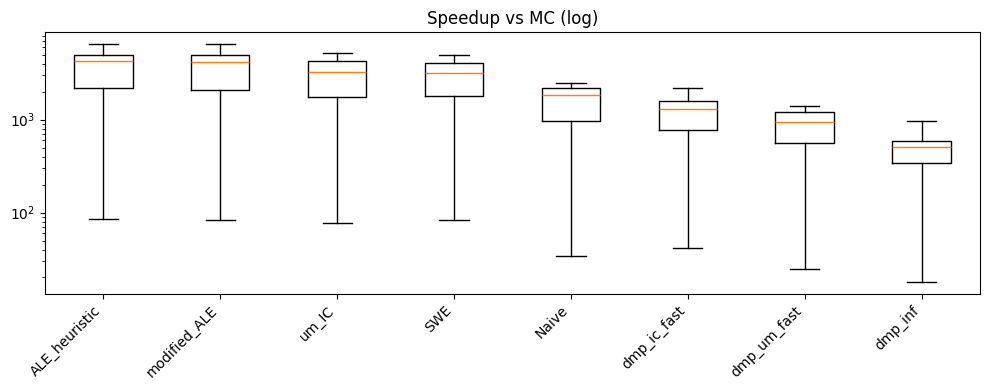

In [50]:
def boxplot_metric(df, metric, by="approximation", title=None, logy=False):
    order = (df.groupby(by)[metric].median().sort_values().index.tolist()
             if metric in ["rmse", "time_ic_approx"] else
             df.groupby(by)[metric].median().sort_values(ascending=False).index.tolist())

    data = [df.loc[df[by] == k, metric].dropna().values for k in order]

    plt.figure(figsize=(10, 4))
    plt.boxplot(data, labels=order, showfliers=False)
    plt.xticks(rotation=45, ha="right")
    if logy:
        plt.yscale("log")
    plt.title(title or f"{metric} by {by}")
    plt.tight_layout()
    plt.show()

boxplot_metric(df[(df["dataset"]=="Anybeat") & (df["edge_method"]=="random_0.1") & (df["prob_selected"]==0.01)], 
               "rmse", title="RMSE across all datasets/conditions")
boxplot_metric(df, "spearman", title="Spearman across all datasets/conditions")
boxplot_metric(df, "auc", title="AUC across all datasets/conditions")
boxplot_metric(df, "time_ic_approx", title="Approximation runtime (log)", logy=True)
boxplot_metric(df, "speedup", title="Speedup vs MC (log)", logy=True)

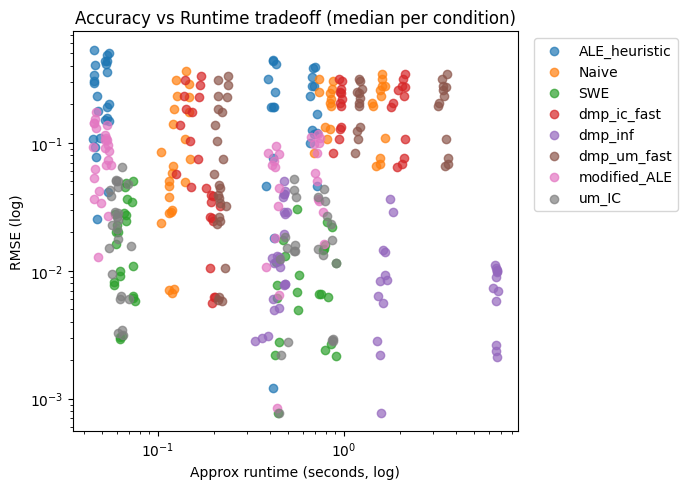

In [35]:
# Aggregate to reduce clutter (median within each condition)
agg_cols = ["dataset", "prob_selected", "edge_method", "approximation"]
plot_df = (df.groupby(agg_cols)
             .agg(rmse=("rmse", "median"),
                  spearman=("spearman", "median"),
                  auc=("auc", "median"),
                  time_ic_approx=("time_ic_approx", "median"),
                  speedup=("speedup", "median"))
             .reset_index())

plt.figure(figsize=(7, 5))
for appr, g in plot_df.groupby("approximation"):
    plt.scatter(g["time_ic_approx"], g["rmse"], label=appr, alpha=0.7)

plt.xscale("log")
plt.yscale("log")  # rmse often benefits from log scale too
plt.xlabel("Approx runtime (seconds, log)")
plt.ylabel("RMSE (log)")
plt.title("Accuracy vs Runtime tradeoff (median per condition)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

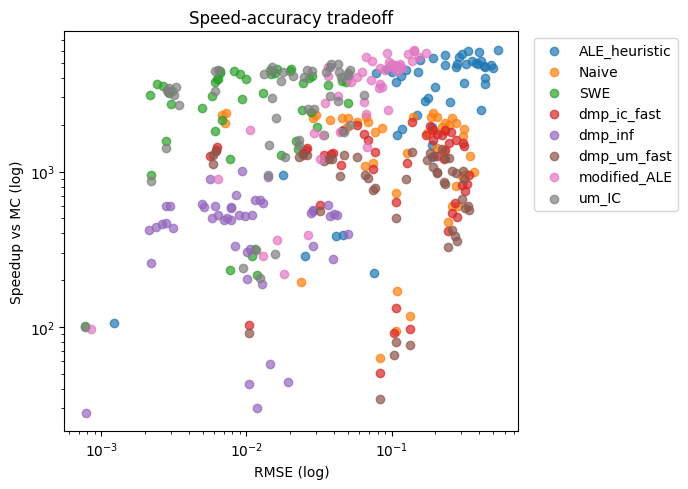

In [31]:
plt.figure(figsize=(7, 5))
for appr, g in plot_df.groupby("approximation"):
    plt.scatter(g["rmse"], g["speedup"], label=appr, alpha=0.7)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("RMSE (log)")
plt.ylabel("Speedup vs MC (log)")
plt.title("Speed-accuracy tradeoff")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [32]:
def winner_counts(df, metric, higher_is_better):
    cols = ["dataset", "prob_selected", "edge_method"]
    g = df.copy()

    # Choose winner per condition
    if higher_is_better:
        winners = g.loc[g.groupby(cols)[metric].idxmax()]
    else:
        winners = g.loc[g.groupby(cols)[metric].idxmin()]

    counts = (winners["approximation"]
              .value_counts()
              .rename(f"wins_{metric}")
              .to_frame())
    return counts

wins_rmse = winner_counts(df, "rmse", higher_is_better=False)
wins_spear = winner_counts(df, "spearman", higher_is_better=True)
wins_auc = winner_counts(df, "auc", higher_is_better=True)
wins_speed = winner_counts(df, "speedup", higher_is_better=True)

wins = wins_rmse.join(wins_spear, how="outer").join(wins_auc, how="outer").join(wins_speed, how="outer").fillna(0).astype(int)
wins.sort_values(list(wins.columns), ascending=False)


,wins_rmse,wins_spearman,wins_auc,wins_speedup
approximation,,,,
dmp_inf,25,32,23,0
SWE,12,7,17,0
dmp_um_fast,9,5,4,0
dmp_ic_fast,2,1,2,0
modified_ALE,0,2,0,19
ALE_heuristic,0,1,0,29
um_IC,0,0,2,0


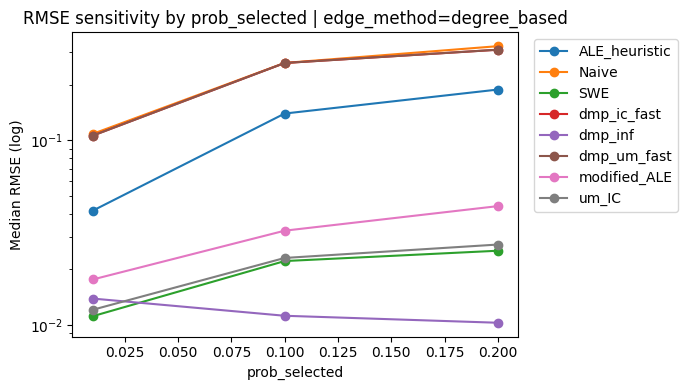

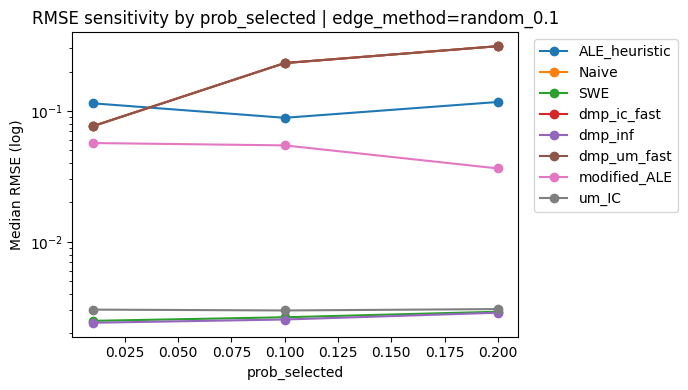

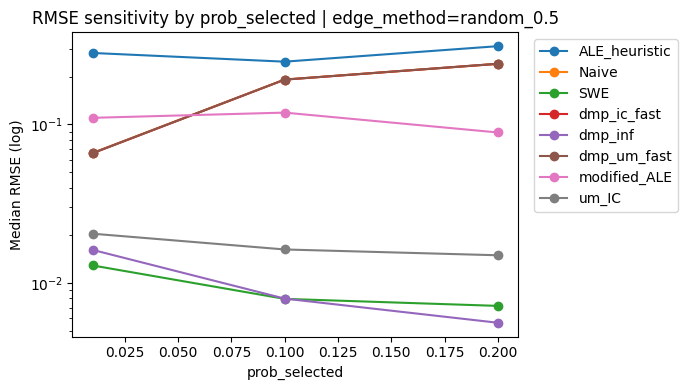

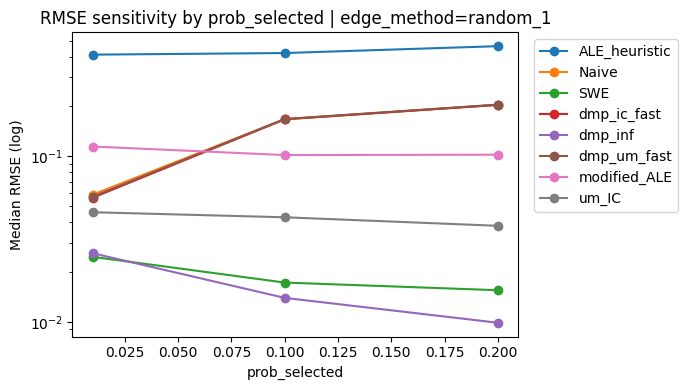

In [66]:
# Example: RMSE vs prob_selected per approximation, one plot per edge_method
for edge_method, g in df.groupby("edge_method"):
    tmp = (g.groupby(["prob_selected", "approximation"])["rmse"]
             .median()
             .reset_index()
             .sort_values("prob_selected"))

    plt.figure(figsize=(7, 4))
    for appr, gg in tmp.groupby("approximation"):
        plt.plot(gg["prob_selected"], gg["rmse"], marker="o", label=appr)

    plt.yscale("log")
    plt.xlabel("prob_selected")
    plt.ylabel("Median RMSE (log)")
    plt.title(f"RMSE sensitivity by prob_selected | edge_method={edge_method}")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
